In [24]:
import pandas as pd
from langchain.tools import BaseTool
from langchain_experimental.agents import create_pandas_dataframe_agent
from langchain_groq import ChatGroq
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

In [2]:
#Reading in the data 

ts_data = pd.read_csv('Electric_Production.csv')
ts_data['DATE'] = pd.to_datetime(ts_data['DATE'],format='%d/%m/%Y')

ts_data.head()

,DATE,IPG2211A2N
0,1985-01-01,72.5052
1,1985-01-02,70.6720
2,1985-01-03,62.4502
3,1985-01-04,57.4714
4,1985-01-05,55.3151


In [3]:
ts_data = ts_data.sort_values(by='DATE')

# Check time intervals
ts_data['delta'] = ts_data['DATE'] - ts_data['DATE'].shift(1)

ts_data[['DATE', 'delta']].head()

,DATE,delta
0,1985-01-01,NaT
1,1985-01-02,1 days
2,1985-01-03,1 days
3,1985-01-04,1 days
4,1985-01-05,1 days


In [4]:
ts_data['delta'].value_counts()

delta
1 days      363
354 days     25
355 days      8
Name: count, dtype: int64

In [5]:
#So that intervals are evenly spaced out, we take the rows with a delta of 1 day and ignore the rest.
ts_data_daily = ts_data[~ts_data['delta'].isin(['354 days','355 days'])]

/var/folders/xp/r07slbbd11v896_crn62zqx40000gp/T/ipykernel_32250/2002995474.py:2: FutureWarning: The behavior of 'isin' with dtype=timedelta64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  ts_data_daily = ts_data[~ts_data['delta'].isin(['354 days','355 days'])]


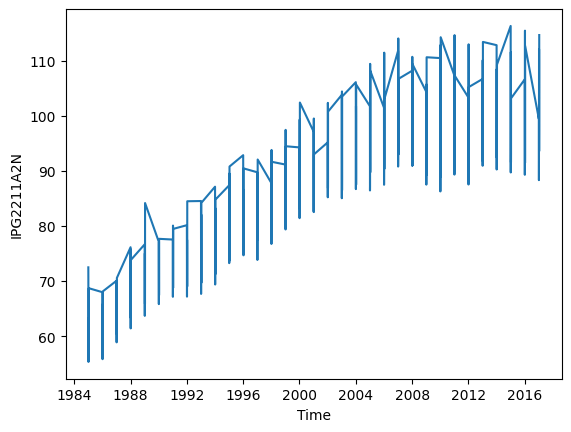

In [6]:
#To get a feel for the data, we can plot a line chart to visualise

plt.plot(ts_data_daily['DATE'],ts_data_daily['IPG2211A2N'])
plt.xlabel('Time')
plt.ylabel('IPG2211A2N')
plt.show()

In [7]:
#Check for missing values 

ts_data_daily.isna().sum()

DATE          0
IPG2211A2N    0
delta         1
dtype: int64

In [8]:
#To perform time series forecasting, we can use ARIMA model which assumes the data is stationary i.e the mean and variance is constant and there is no seasonality 
#Thus we can use ADF (Augmented Dickey Fuller) Test to check for stationarity

def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [9]:
check_stationarity(ts_data_daily['IPG2211A2N'])

The series is NOT stationary


In [19]:
#Differencing is a trick to convert from non-stationary to stationary
data_diff = np.diff(ts_data_daily['IPG2211A2N'])

The series is stationary
None


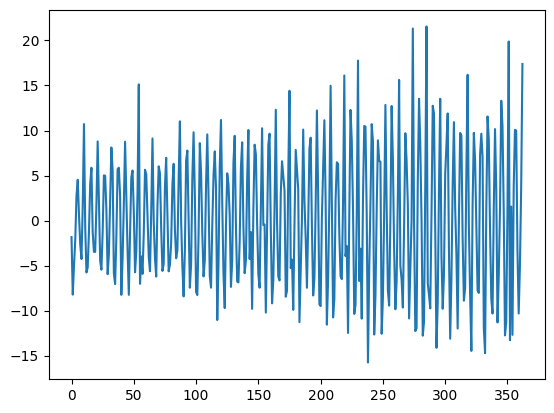

In [20]:
print(check_stationarity(data_diff))
plt.plot(data_diff)

In [29]:
#Taking the stationary data and split into train and test data 
X = pd.Series(data_diff).values
split = int(0.7*len(X))

train = X[:split]
test = X[split:]

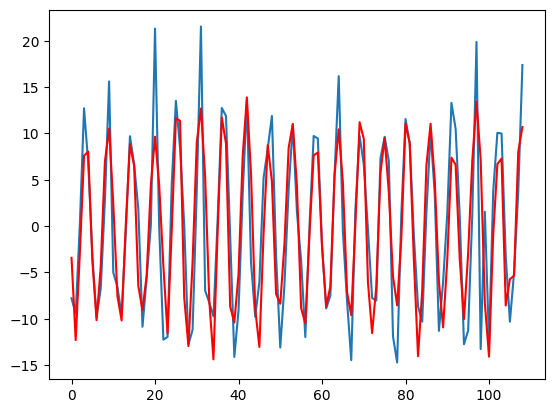

In [45]:
#Perform a rolling forecasting by repeatedly fitting the ARIMIA model on history data and predicting the next value 
history = [x for x in train]
predictions = []

for t in range(len(test)):
 model = ARIMA(history, order=(5,1,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)

plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [ ]:
llm_model = ChatGroq(temperature=0, groq_api_key='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', model_name="mixtral-8x7b-32768")

In [ ]:
FORMAT_INSTRUCTIONS = """Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do, what action to take
Action: The appropriate tool to call to perform action
Action Input: the input to the action, never add backticks "`" around the action input
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question"""

In [ ]:
instructions = """
Task Description:
1.Your task involves analyzing queries and responding appropriately using data from Pandas DataFrame. Follow these guidelines to ensure accuracy and consistency in your responses:

2.Provision of Table Data for Matching Queries:
Direct Match: Upon receiving a query, carefully verify the data within the tables. If the query matches any data or values in the tables, directly provide that table data as the response. Ensure that responses are precisely data-driven, offering the exact information requested without deviation.

Calculations: If calculations are required to provide the response, write appropriate Pandas functions and execute them to deliver precise and accurate answers. Clearly explain each calculation step by step, making any necessary assumptions and stating them at the beginning of your response.

3.Specific Response for Non-matching Queries:
Non-match Identified: In cases where the query does not match any data or values within the tables or if you are unable to perform the requested calculation, issue a standard response: "This query does not have a corresponding answer in the provided table data." Use this response uniformly for all instances where a query fails to find a corresponding match in the Pandas DataFrame, reaffirming the absence of relevant data.

4.Key Focus:
The primary objective is to offer responses that are directly tied to the presence or absence of matching data within the Pandas DataFrame.
Emphasize the importance of meticulous verification for each query to accurately determine the match status.
For any calculations, take a deep breath and think through the steps carefully. Explain each step clearly and logically.

For any calculations, please take a deep breath and think step by step. Then explain the calculation step by step. Make assumptions and state them at the start of response as needed
     """

In [ ]:
agent_without_tool = create_pandas_dataframe_agent(llm=llm_model, df=ts_data,verbose=True,stop=['\n'],agent_kwargs={
        'prefix': instructions, 
        'format_instructions': FORMAT_INSTRUCTIONS
    })

In [ ]:
agent_without_tool.invoke('Plot a line graph showing the IPG2211A2N with dates on the x axis. Make sure to label the axes and provide an appropriate title')